### How do the 2016 presidential candidates leverage their Twitter accounts?
Social media, and Twitter in particular, is playing an increasingly larger role in political campaigns. How do the 2016 presidential candidates use their Twitter accounts and what can we learn about their PR strategies from this analysis? How do these trends change over time and in response to key events in the election cycle? 

To answer this question, we'll take a look at the main topics covered by tweets and the sentiment and mood (e.g. imperative or "call to action" or indicative/fact explication) surrounding these topics over time. The analysis utilizes k-means clustering and topic modeling (latent dirichlet allocation) with tf-idf weighting, supplemented by sentiment analysis through vaderSentiment and mood/subjectivity/modality analysis through pattern and textblob.

The dataset contains approximately 16,000 tweets collected prior to Super Tuesday for five candidates:
* Hillary Clinton
* Ted Cruz
* Marco Rubio
* Bernie Sanders
* Donald Trump

Diana Lam  
March 2016 

### Table of Contents  
[1. Import necessary packages & data](#1)  
[2. Exploratory data analysis on candidate metadata](#2)  
[3. Add features for NLP analysis](#3)  
[4. Compare candidate sentiment, subjectivity and mood](#4)  
[5. Prepare tf-idf and count vectorizers; investigate terms by count](#5)  
[6. Apply k-means clustering to determine topics](#6)  
[7. Apply topic modeling with LDA and visualize with pyLDAvis to adjust parameters](#7)  
[8. Investigate tweet composition by topic](#8)

### <a id='1'></a> 1. Import necessary packages & data from mongoDB; convert to df

In [3]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from textblob import TextBlob as blob
from scipy import stats
from pymongo import MongoClient
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import sentiment as vaderSentiment 

# sentiment analysis
from textblob.sentiments import NaiveBayesAnalyzer
from pattern.en import sentiment, mood, modality, wordnet, ADJECTIVE

# text parsing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from spacy.en import English, STOPWORDS
from nltk.tokenize import sent_tokenize, word_tokenize

# modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
import lda
from sklearn.decomposition import PCA, LatentDirichletAllocation

# visualization
import pyLDAvis

%matplotlib inline

In [105]:
# define mongodb parameters
client = MongoClient()
db = client.tweets

coll_dict = {'trump': db.trump, 
             'clinton' : db.clinton, 
             'sanders' : db.sanders, 
             'cruz' : db.cruz, 
             'rubio' : db.rubio}

def into_mongo(collection, results):
    coll = collection
    for tweet in results:
        coll.insert_one(tweet)
        
def out_of_mongo(collection):
    tweet_list = []
    for tweet in collection.find():
        tweet_list.append(tweet)
    return tweet_list

In [113]:
dt_data = out_of_mongo(coll_dict['trump'])
hc_data = out_of_mongo(coll_dict['clinton'])
bs_data = out_of_mongo(coll_dict['sanders'])
tc_data = out_of_mongo(coll_dict['cruz'])
mr_data = out_of_mongo(coll_dict['rubio'])

In [620]:
def data_to_df(data, name):
    """Convert list object of tweet data into dataframe; keep only important columns.
    Args:
    data (list of dict, json) -- tweet data
    name (string) -- name of candidate, used to populate candidate column
    """
    # variables explained: https://dev.twitter.com/overview/api/tweets
    df = pd.DataFrame(data)
    df.drop_duplicates(subset = 'id', inplace = True)
    keep = ['id', 'created_at', 'text', 
            'favorite_count', 'retweet_count', 
            'coordinates', 'place', 
            'is_quote_status', 'quoted_status', 'quoted_status_id', 
            'in_reply_to_screen_name', 'in_reply_to_status_id', 'retweeted_status', 
            'entities']
    df = df[keep]
    df['candidate'] = name
    return df

In [621]:
dt = data_to_df(dt_data, 'trump')
hc = data_to_df(hc_data, 'clinton')
bs = data_to_df(bs_data, 'sanders')
tc = data_to_df(tc_data, 'cruz')
mr = data_to_df(mr_data, 'rubio')

In [622]:
tweets = pd.concat([dt, hc, bs, tc, mr], ignore_index = True)

In [98]:
# workspace to get last id for updating tweets
def get_last_id(df):
    return df.loc[0, 'id']

dfs = [dt, hc, bs, tc, mr]
names = ['trump', 'clinton', 'sanders', 'cruz', 'rubio']
last_id = {name : get_last_id(cand) for name in names for cand in dfs}

last_id

###  <a id='2'></a>2. Conduct exploratory data analysis on candidate metadata

Features investigated:
* Number of favorites
* Number of retweets 
* Volume of tweets over time (by week, by month)

In [78]:
by_cand = tweets.groupby('candidate')

In [79]:
favs = by_cand[['favorite_count', 'retweet_count']].mean()

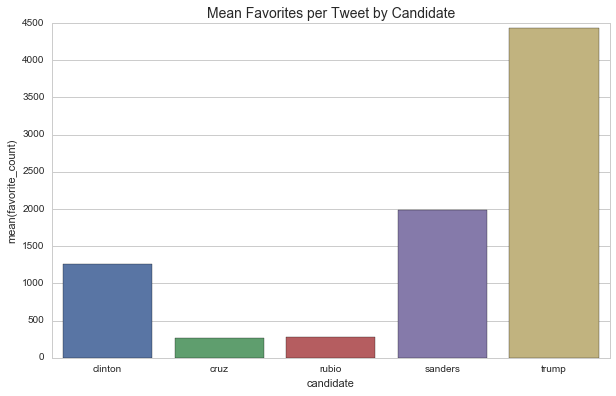

In [92]:
plt.figure(figsize = (10, 6))
sns.barplot(favs.index, 'favorite_count', data = favs)
plt.title('Mean Favorites per Tweet by Candidate', fontsize = 14)
plt.show()

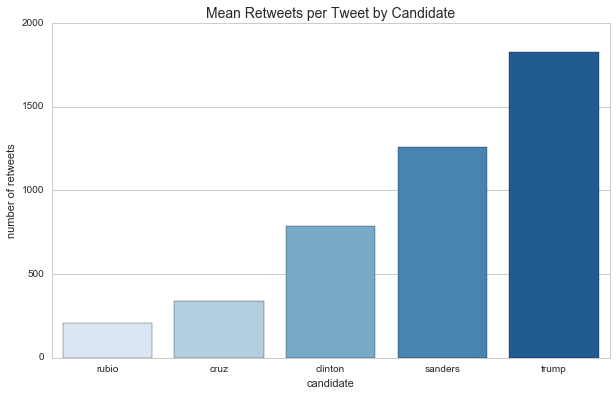

In [91]:
plt.figure(figsize = (10, 6))
sns.barplot(favs.index, 'retweet_count', data = favs, palette = "Blues", order = ['rubio', 'cruz', 'clinton', 'sanders', 'trump'])
plt.title('Mean Retweets per Tweet by Candidate', fontsize = 14)
plt.ylabel('number of retweets')
plt.xlabel('candidate')
#plt.savefig('retweets-chart.png', dpi = 500)
plt.show()

#### Add features to investigate volume of tweets and retweets over time

In [638]:
def is_retweet(retweeted_status):
    """Check if tweet is retweet."""
    try:
        if np.isnan(retweeted_status) == True:
            return 
    except:
        return 1

In [690]:
def get_week(date):
    """Return start of week (Monday) given a date."""
    week = date - timedelta(days = date.weekday())
    return week

In [639]:
def add_metadata(df):
    """Add date, is retweet, month, and week features to df."""
    # add date as datetime object
    df.loc[:, 'date'] = df.loc[:, 'created_at'].apply(lambda x: pd.to_datetime(x).date())
    
    # add if retweet
    df.loc[:, 'is_retweet'] = df.loc[:, 'retweeted_status'].apply(is_retweet)
    
    # add week
    df.loc[:, 'week'] = df.loc[:, 'date'].apply(get_week)
    
    # add month
    df.loc[:, 'month'] = df.loc[:, 'date'].apply(lambda x: x.replace(day = 1))

In [1002]:
add_metadata2(tweets)

#### By week analysis

In [700]:
bycand_bydate = tweets.groupby(['candidate', 'week'])

In [701]:
tweets_bydate = bycand_bydate[['text', 'is_retweet']].count()

In [1015]:
def plot_time(counted):
    """Plot tweets over time."""
    cands = ['clinton', 'sanders', 'trump', 'rubio', 'cruz']
    plt.figure(figsize = (10, 6))
    for cand in cands:
        plt.plot(counted.loc[cand, 'text'], label = cand)
    plt.legend(loc = 'best')
    plt.show()

In [718]:
start = get_week(pd.to_datetime('08/01/2015').date())
end = get_week(pd.to_datetime('02/28/2016').date())

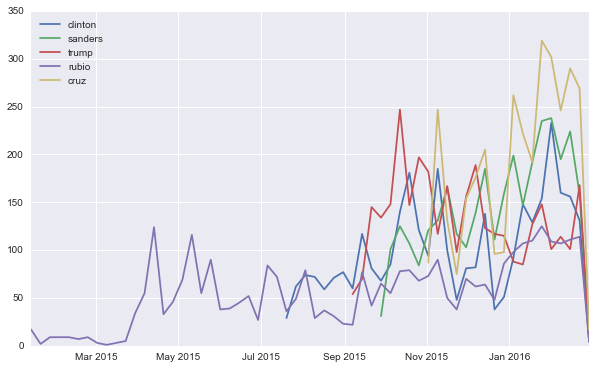

In [1016]:
plot_time(tweets_bydate)

Yikes! Too much variation to be interpretable. Let's try it by month next.

#### By month analysis

In [1005]:
bymonth = tweets.groupby(['candidate', 'month'])
tweets_bymonth = bymonth[['text', 'is_retweet']].count()

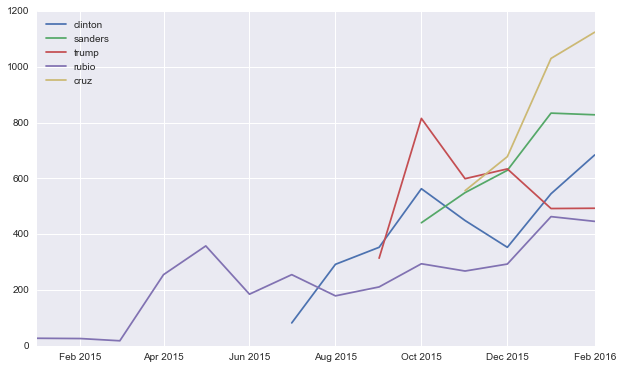

In [1017]:
plot_time(tweets_bymonth)

This is better. We can see that Cruz is leading in current tweet volume, followed by Sanders, Clinton, Trump, and Rubio. Trump's volume is declining over time whereas all of the other candidates' activity is increasing.

###  <a id='3'></a>3. Add features for NLP analysis

**Define functions to tokenize and add sentiment, modality, and mood scores.**

In [7]:
def get_sentences(text):
    """Return list of sentences in tweet."""
    sents = sent_tokenize(text)
    return [sent for sent in sents if re.search('[a-zA-Z]', sent) != None]

In [193]:
def get_polarity(sents):
    """Return polarity score for each sentence in text."""
    return [sentiment(x)[0] for x in sents]

def get_vader_sentiment(text):
    """Return vaderSentiment score for text."""
    try:
        return vaderSentiment(text)['compound']
    except:
        return 0
    
def get_subjectivity(sents):
    """Return subjectivity score for each sentence in text."""
    return [sentiment(x)[1] for x in sents]

def get_is_fact(sents):
    """Return modality score for each sentence in text."""
    return [modality(x) for x in sents]

def get_mood(sents):
    """Return modality score for each sentence in text."""
    return [mood(x) for x in sents]

def get_mood_mode(mood):
    """Return most commonly occuring modality score for each tweet."""
    try:
        return stats.mode(mood)[0][0]
    except:
        return mood

In [885]:
# get hashtags and mentions
def get_hashtags(entities):
    """Return a list of all hashtags used in tweet."""
    try:
        return [entities['hashtags'][i]['text'] for i in range(len(entities['hashtags']))]
    except:
        return 

def get_user_mentions(entities):
    """Return a list of all user mentions in tweet."""
    try:
        return [entities['user_mentions'][i]['screen_name'] for i in range(len(entities['user_mentions']))]
    except:
        return
    
def get_first_hashtag(entities):
    """Return first hashtag used in tweet."""
    try:
        return [entities['hashtags'][i]['text'] for i in range(len(entities['hashtags']))][0]
    except:
        return 

def get_first_user_mentions(entities):
    """Return first user mentioned in tweet."""
    try:
        return [entities['user_mentions'][i]['screen_name'] for i in range(len(entities['user_mentions']))][0]
    except:
        return

def has_media(entities):
    """Return type of media if tweet contains media, blank if not."""
    try:
        return entities['media'][0]['type']
    except:
        return
    
def hashtags_about_self(hashtags, candidate):
    """Check if hashtags refer to candidate. Return total number of self-referencing hashtags."""
    counter = 0
    for ht in hashtags:
        if any(substring in ht.lower() for substring in cand_stopwords[candidate]):
            counter += 1
    return counter

In [467]:
def get_tokens(text):  
    """Return lemmatized tokens for each review."""
    text = re.sub(r"http\S+", "hyperlink", text) # replace urls with str hyperlink
    letters_only = re.sub("[^a-zA-Z0-9@]", " ", text) # remove everything except numbers, hashtags, and @
    words = ' '.join(letters_only.lower().split())
    try:
        tokens = [token.lemma_ for token in nlp(words)] # get lemmas
    except:
        tokens = [token.lemma_ for token in nlp(words.decode('utf8'))] # get lemmas
    filtered = [t for t in tokens if t != '' and t != ' ' and t != '\n' and t != '\n\n'] # remove any remaining spaces
    filtered = [t for t in filtered if any(letter.isalpha() for letter in t)] # remove numbers without any letters attached
    return ' '.join(filtered)

In [659]:
def get_features(df):
    # add sentences
    %time df.loc[:, 'sentences'] = df.loc[:, 'text'].apply(get_sentences)
    
    # add tokens
    %time df.loc[:, 'tokens'] = df.loc[:, 'text'].apply(get_tokens)
    
    # add sentiment, subjectivity, modality, and mood scores by sentence
    %time df.loc[:, 'sentiment'] = df.loc[:, 'sentences'].apply(get_polarity)
    %time df.loc[:, 'mood'] = df.loc[:, 'sentences'].apply(get_mood)
    %time df.loc[:, 'modality'] = df.loc[:, 'sentences'].apply(get_is_fact)
    %time df.loc[:, 'subjectivity'] = df.loc[:, 'sentences'].apply(get_subjectivity)
    %time df.loc[:, 'vader_sentiment'] = df.loc[:, 'text'].apply(get_vader_sentiment)

    
    # average the above scores
    %time df.loc[:, 'avg_sentiment'] = df.loc[:, 'sentiment'].apply(np.mean)
    %time df.loc[:, 'mode_mood'] = df.loc[:, 'mood'].apply(get_mood_mode)
    %time df.loc[:, 'avg_modality'] = df.loc[:, 'modality'].apply(np.mean)
    %time df.loc[:, 'avg_subjectivity'] = df.loc[:, 'subjectivity'].apply(np.mean)
    
    # count number of tokens
    df.loc[:, 'num_tokens'] = df.loc[:, 'tokens'].apply(lambda x: len(x.split()))
    
    # count number of characters
    df.loc[:, 'num_chars'] = df.loc[:, 'tokens'].apply(lambda x: len(x))
    
    # add user mentions, hashtags, and media
    df.loc[:, 'hashtags'] = df.loc[:, 'entities'].apply(get_hashtags)
    df.loc[:, 'user_mentions'] = df.loc[:, 'entities'].apply(get_user_mentions)
    df.loc[:, 'media'] = df.loc[:, 'entities'].apply(has_media)
    
    # count number of hyperlinks
    df.loc[:, 'num_hyperlinks'] = df.loc[:, 'tokens'].apply(lambda x: x.split().count('hyperlink'))
    
    # check if hashtags reference self
    df.loc[:, 'hashtags_about_self'] = df.apply(lambda row: hashtags_about_self(row.hashtags, row.candidate), axis = 1)
    
    # return first hashtag
    df.loc[:, 'first_hashtag'] = df.loc[:, 'entities'].apply(get_first_hashtag)
    
    # return first user mention
    df.loc[:, 'first_user_mention'] = df.loc[:, 'entities'].apply(get_first_user_mentions)

    return df

In [11]:
# load spacy, stopwords, and punctuation
nlp = English()
stop = STOPWORDS
punct = {p for p in string.punctuation if p != '@' and p != '#'}

#### Add features to tweets df.

In [660]:
get_features(tweets)

CPU times: user 1.76 s, sys: 198 ms, total: 1.96 s
Wall time: 2.03 s
CPU times: user 28.1 s, sys: 2.09 s, total: 30.2 s
Wall time: 31.8 s
CPU times: user 5.61 s, sys: 241 ms, total: 5.85 s
Wall time: 5.91 s
CPU times: user 53.9 s, sys: 726 ms, total: 54.7 s
Wall time: 55.7 s
CPU times: user 58.4 s, sys: 480 ms, total: 58.9 s
Wall time: 59 s
CPU times: user 5.21 s, sys: 144 ms, total: 5.35 s
Wall time: 5.29 s
CPU times: user 223 ms, sys: 9.43 ms, total: 233 ms
Wall time: 243 ms
CPU times: user 7.42 s, sys: 56.6 ms, total: 7.48 s
Wall time: 7.52 s
CPU times: user 207 ms, sys: 7.42 ms, total: 214 ms
Wall time: 226 ms
CPU times: user 203 ms, sys: 6.24 ms, total: 209 ms
Wall time: 213 ms


,id,created_at,text,favorite_count,retweet_count,coordinates,place,is_quote_status,quoted_status,quoted_status_id,...,mode_mood,avg_modality,avg_subjectivity,num_tokens,num_chars,hashtags,user_mentions,media,num_hyperlinks,hashtags_about_self
0,704339457974132736,Mon Feb 29 16:16:27 +0000 2016,#Trump2016 #TrumpInstagram: https://t.co/tzHtn...,973,454,None,None,False,NaN,NaN,...,indicative,0.750000,0.000000,4,44,"{TrumpInstagram, Trump2016}",{},photo,2,2
1,704332561296855040,Mon Feb 29 15:49:03 +0000 2016,I am self funding my campaign and only work fo...,3004,1114,None,None,False,NaN,NaN,...,indicative,0.500000,0.250000,18,104,{Trump2016},{},photo,2,1
2,704324651384762368,Mon Feb 29 15:17:37 +0000 2016,"""Hillary could lose to Trump in Democratic New...",3750,1424,None,None,False,NaN,NaN,...,conditional,0.178571,0.454545,12,92,"{Trump2016, MakeAmericaGreatAgain}",{},None,1,2
3,704312346706124800,Mon Feb 29 14:28:43 +0000 2016,"Join me in Columbus, Ohio tomorrow!\n#MakeAmer...",3459,1178,None,None,False,NaN,NaN,...,imperative,0.875000,0.000000,9,75,"{Trump2016, MakeAmericaGreatAgain}",{},None,1,2
4,704285794643668992,Mon Feb 29 12:43:13 +0000 2016,Thank you America! Get out &amp; VOTE tomorrow...,6101,2303,None,None,False,NaN,NaN,...,imperative,0.833333,0.000000,12,95,"{MakeAmericaGreatAgain, Trump2016}",{},photo,2,2
5,704284013461180416,Mon Feb 29 12:36:08 +0000 2016,"My sons, Don and Eric, are on @foxandfriends n...",4947,974,None,None,False,NaN,NaN,...,indicative,0.708333,0.312500,12,59,{},{foxandfriends},None,0,0
6,704111284095225856,Mon Feb 29 01:09:46 +0000 2016,Thank you @SenatorSessions!\n#MakeAmericaGreat...,10226,3903,None,None,False,NaN,NaN,...,imperative,0.875000,0.000000,7,77,"{Trump2016, MakeAmericaGreatAgain}",{SenatorSessions},photo,2,2
7,704100078743625729,Mon Feb 29 00:25:14 +0000 2016,"THANK YOU ALABAMA! 32,000 supporters tonight. ...",14880,6019,None,None,False,NaN,NaN,...,imperative,0.850000,0.150000,18,106,{},{},photo,1,0
8,704064261413273601,Sun Feb 28 22:02:55 +0000 2016,Our law enforcement officers deserve our appre...,12093,4444,None,None,False,NaN,NaN,...,imperative,0.625000,0.450000,16,109,{},{},photo,2,0
9,704062727082385409,Sun Feb 28 21:56:49 +0000 2016,I will be making a big surprise announcement t...,11739,3771,None,None,False,NaN,NaN,...,indicative,0.833333,0.183333,20,124,{Trump2016},{},None,0,1


In [1021]:
# limit to only tweets longer than 75 characters
long_tweets = tweets[tweets.num_chars > 75]

#### Pickle for future reloading.

In [1673]:
# pickle
with open('pickled/tweetsdf.pkl', 'w') as picklefile:
    pickle.dump(tweets, picklefile)
    
with open('pickled/long_tweetsdf.pkl', 'w') as picklefile:
    pickle.dump(long_tweets, picklefile)

In [4]:
# open pickled file
with open('pickled/long_tweetsdf.pkl', 'r') as picklefile:
    long_tweets = pickle.load(picklefile)
    
with open('pickled/tweetsdf.pkl', 'r') as picklefile:
    tweets = pickle.load(picklefile)

###  <a id='4'></a>4. Compare candidate sentiment, subjectivity and mood

In [201]:
by_cand = long_tweets.groupby('candidate')

#### Subjectivity

In [159]:
subjectivity = by_cand['avg_subjectivity'].mean()
subjectivity

candidate
clinton    0.200789
cruz       0.204096
rubio      0.239222
sanders    0.220332
trump      0.362980
Name: avg_subjectivity, dtype: float64

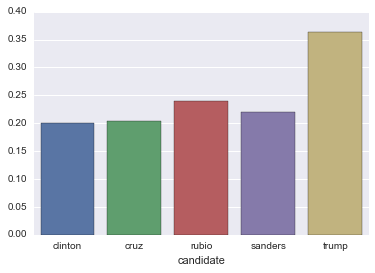

In [162]:
sns.barplot(subjectivity.index, subjectivity.values)

#### Sentiment

In [163]:
total_sentiment = by_cand['avg_sentiment'].sum()
total_sentiment

candidate
clinton    197.616368
cruz       187.302711
rubio      245.923086
sanders    170.133349
trump      309.661053
Name: avg_sentiment, dtype: float64

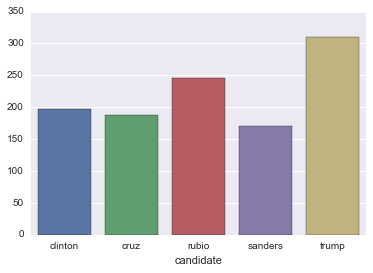

In [164]:
sns.barplot(total_sentiment.index, total_sentiment.values)

In [165]:
avg_sentiment = by_cand['avg_sentiment'].mean()
avg_sentiment

candidate
clinton    0.077618
cruz       0.086275
rubio      0.124329
sanders    0.060697
trump      0.122687
Name: avg_sentiment, dtype: float64

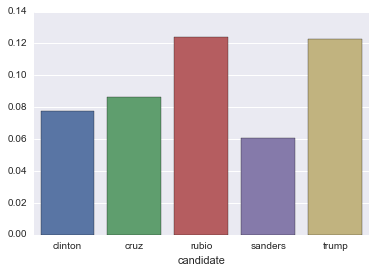

In [166]:
sns.barplot(avg_sentiment.index, avg_sentiment.values)

#### Mood

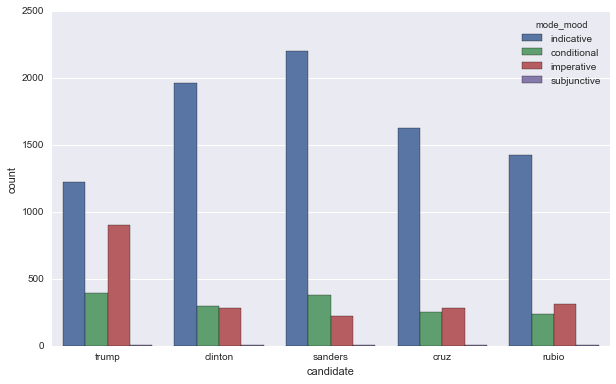

In [203]:
plt.figure(figsize = (10, 6))
sns.countplot('candidate', data = long_tweets, hue = 'mode_mood')

### <a id='5'></a>5. Prepare tf-idf and count vectorizers; investigate terms by count

In [93]:
cand_stopwords = {'clinton': {u'hillary', u'clinton', u'hillaryclinton'}, 
                  'sanders': {u'bernie', u'sanders', u'berniesanders', u'feelthebern', u'sander'},
                  'cruz' : {u'ted', u'cruz', u'tedcruz', u'cruzcrew'},
                  'rubio' : {u'marco', u'rubio', u'marcorubio', u'teammarco'}, 
                  'trump' : {u'donald', u'trump', u'donaldtrump', u'realdonaldtrump', u'makeamericagreatagain'}}

In [94]:
# add general stopwords
stop = stop.union({u'rt', u'amp', u'hyperlink'})

# stopwords with all candidate names
all_stop = stop.union({u'hillary', u'clinton', u'hillaryclinton', 
                       u'bernie', u'sanders', u'berniesanders', u'feelthebern', u'sander', 
                       u'ted', u'cruz', u'tedcruz', u'cruzcrew',
                       u'marco', u'rubio', u'marcorubio', u'teammarco', 
                       u'donald', u'trump', u'donaldtrump', u'realdonaldtrump', u'makeamericagreatagain'})

In [95]:
candidates = ['clinton', 'sanders', 'trump', 'cruz', 'rubio']

In [96]:
def get_word_counts(cand, df):
    count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = stop.union(cand_stopwords[cand]), 
                                       max_features = 1000,
                                       ngram_range = (1, 3), 
                                       min_df = 3) 
    matrix = count_vect.fit_transform(df[df.candidate == cand].tokens)
    grams = count_vect.get_feature_names()
    dist = np.sum(matrix.toarray(), axis = 0)
    grams_sorted = sorted(zip(grams, dist), key = lambda x: x[1], reverse = True)[:10]
    print '\n', cand, '\n'
    print grams_sorted

In [99]:
for c in candidates:
    get_word_counts(c, long_tweets)

### <a id='6'></a>6. Apply k-means clustering to determine topics

In [243]:
def get_clusters_counts(cand, df, true_k = 5):
    count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = cand_stopwords, 
                                       max_features = 20000,
                                       ngram_range = (1, 3), 
                                       min_df = 3) 
    matrix = count_vect.fit_transform(df[df.candidate == cand].tokens)
    grams = count_vect.get_feature_names()
    km = KMeans(n_clusters = true_k)
    km.fit(matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    print '\n', cand
    for i in range(true_k):
        print "\nCluster %d:" % i
        print ', '.join([grams[ind] for ind in order_centroids[i, :25]]) 
    return km

In [245]:
def get_clusters_tfidf(cand, df, true_k = 5):
    """Fit kmeans cluster model and print clusters given text vector. Return model."""
    vect = TfidfVectorizer(max_df = 0.5, max_features = 200000,
                                 min_df = 5, stop_words = cand_stopwords,
                                 use_idf = True, tokenizer = None, ngram_range=(1, 3))
    matrix = vect.fit_transform(df[df.candidate == cand].tokens) 
    terms = vect.get_feature_names()
    km = KMeans(n_clusters = true_k)
    km.fit(matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    print '\n', cand
    for i in range(true_k):
        print "\nCluster %d:" % i
        print ', '.join([terms[ind] for ind in order_centroids[i, :25]]) 
    return km

#### Without tfidf

In [244]:
clinton_model = get_clusters_counts('clinton', long_tweets, 50)


clinton

Cluster 0:
community, black, flint, lsd, esq, lsd esq, help, american, demdebate, america, ensure, racial, sow, insult, year, raid, end, fear, lorellapraeli, hand, strength, economic, hold accountable, hold, thanks

Cluster 1:
support, proud, american, stand, campaign, proud support, candidate, support campaign, presidential, fight, thank, need, plan, talk, raise, presidential candidate, woman, need support, today, hbcus, grateful support, business, grateful, tonight, time

Cluster 2:
country, american, president, economy, family, people, serve, muslim, american country, muslim american, wrong, job, muslim american country, economy country, proud, change, fight, need, immigration, better, strengthen, gopdebate, adam, united state, country better

Cluster 3:
health, care, affordable, affordable health, affordable health care, health care, quality affordable, quality, quality affordable health, right, human right, human, standwithpp, proud, fight, basic, proud standwithpp, amer

In [239]:
# plot k vs. intertia
inertias = []
for k in range(1, 51):
    mod = get_clusters_counts('clinton', long_tweets, k)
    inertias.append(mod.inertia_)

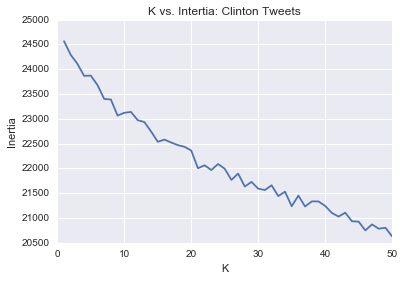

In [241]:
plt.plot(range(1,51), inertias)
plt.title('K vs. Intertia: Clinton Tweets')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

In [228]:
for c in candidates:
    get_clusters_counts(c, long_tweets, true_k = 6)


clinton

Cluster 0:
president, need, demdebate, republican, obama, president obama, need president, woman, state, america, family, country, united, republican president, thebriefing, gun, like, gop, job, billclinton, united state, want, president united state, vote, run president

Cluster 1:
change, climate, climate change, real, act, fight, climate change real, change real, know, president, gopdebate, people, scientist, threaten, need, afford president, afford, republican, discuss, shape, life, candidate, sit, need act, threat

Cluster 2:
gun, violence, gun violence, protect, act, time, family, plan, prevention, community, gun violence prevention, violence prevention, act gun, protect family, act gun violence, better, prevent, family community, end, amendment, time act, stand, demdebate, prevent gun violence, prevent gun

Cluster 3:
right, woman, vote, woman right, fight, voting, human right, human, need, voting right, equal, vote right, protect, reproductive, reproductive right, lgb

#### With tfidf

In [246]:
tfidf_inertias = []
for k in range(1, 51):
    mod = get_clusters_tfidf('clinton', long_tweets, k)
    tfidf_inertias.append(mod.inertia_)

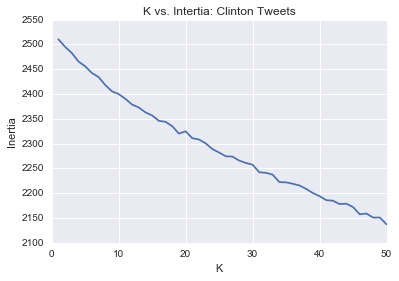

In [248]:
plt.plot(range(1,51), tfidf_inertias)
plt.title('K vs. Intertia: Clinton Tweets')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

In [92]:
cluster_dict = {cand : 3 for cand in candidates}

In [94]:
for c in cluster_dict:
    get_clusters_tfidf(c, long_tweets, true_k = cluster_dict[c])


sanders

Cluster 0:
sander, campaign, live, need, today, new, family, iowa, country, watch, political, american, demdebate, work, join, win, time, america, president, pay, revolution, right, stand, vote, woman

Cluster 1:
people, change, health, care, health care, american, climate change, climate, country, million, campaign, american people, need, real, political, young people, real change, right, million people, stand, young, care right, health care right, want, come

Cluster 2:
wall street, street, wall, greed, big, breakemup, bank, bail, billionaire, class, economy, money, fraud, model wall, business model wall, business model, kid, model, reform, free, debatewithbernie, campaign, administration, behavior, illegal

cruz

Cluster 0:
iowa, president, caucusforcruz, gopdebate, watch, today, support, win, live, new, rally, iacaucus, campaign, vote, conservative, cruzintocaucus, listen, endorse, great, cruztovictory, choosecruz, glennbeck, day, ad, speak

Cluster 1:
join, et, tune, pm,

### <a id='7'></a>7. Apply topic modeling with LDA and visualize with pyLDAvis to adjust parameters

In [37]:
def print_top_words(model, feature_names, n_top_words = 20):
    """Print top words in each topic."""
    for topic_idx, topic in enumerate(model.components_):
        print "\nTopic #%d:" % topic_idx
        print ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

In [323]:
def get_doc_topics(doc_topic_dist):
    """Return list of topics for documents, given doc topic distribution"""
    return [np.argmax(topic) for doc, topic in enumerate(doc_topic_dist)]

#### All candidates; run topic modeling with each tweet as separate document

In [733]:
# with count vectorizer
def get_topics_lda(docs, df, n_topics = 4):   
    count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = all_stop, 
                                       max_features = 10000,
                                       ngram_range = (1, 3), 
                                       min_df = 10) 
    matrix = count_vect.fit_transform(docs)
    vocab = count_vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, doc_topic_prior = .001, max_iter=5,
                learning_method='online', learning_offset=50.,
                random_state=0)
    doc_topic_dists = lda.fit_transform(matrix)
    
    # print topic words
    print "\nTopics in LDA model:", cand
    print_top_words(lda, vocab)
    
    # prepare pyLDAvis stuff 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = docs.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [74]:
# with tf-idf
def get_topics_lda_tfidf(docs, df, n_topics = 4):   
    vect = TfidfVectorizer(max_df = 0.8, max_features = 200000,
                                 min_df = 5, stop_words = all_stop,
                                 use_idf = True, tokenizer = None, ngram_range=(1, 3))
    matrix = vect.fit_transform(docs)
    vocab = vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, doc_topic_prior = .001, max_iter=20,
                learning_method='online', learning_offset=50.,
                random_state=0)
    doc_topic_dists = lda.fit_transform(matrix)
    
    print topic words
    print_top_words(lda, vocab)
    
    # prepare pyLDAvis stuff 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = docs.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [730]:
all_lda, all_doc_topics, all_prepared = get_topics_lda(long_tweets.tokens, long_tweets, 5)

In [731]:
pyLDAvis.display(all_prepared)

In [75]:
all_lda_tfidf, all_doc_topics_tfidf, all_prepared_tfidf = get_topics_lda_tfidf(long_tweets.tokens, long_tweets, 5)

In [936]:
pyLDAvis.display(all_prepared_tfidf)

In [76]:
pyLDAvis.save_html(all_prepared_tfidf, 'final_pyldavis.html')

#### Aggregate tweets by candidate; run topic modeling on aggregated documents

In [811]:
by_cand = long_tweets.groupby('candidate')

def agg_text_by_cand(grouped):
    cands = [cand for cand, series in grouped['tokens']]
    tweets = []
    for cand, series in grouped['tokens']:
        tweets.append(' '.join([text for idx, text in enumerate(series)]))
    return dict(zip(cands, tweets))

In [897]:
def get_topics_lda_agg(docs, n_topics = 4):   
    vect = TfidfVectorizer(max_features = 200000, stop_words = all_stop,
                           use_idf = True, tokenizer = None, ngram_range=(1, 3))
    matrix = vect.fit_transform(docs)
    vocab = vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=10,
                learning_method='online', learning_offset=50.,
                random_state=0)
    doc_topic_dists = lda.fit_transform(matrix)
    
    # prepare pyLDAvis stuff 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = docs.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [834]:
agg_text = agg_text_by_cand(by_cand)

In [835]:
agg_text_df = pd.DataFrame({'candidate': agg_text_by_cand(by_cand).keys(), 'text': agg_text_by_cand(by_cand).values()})

In [860]:
agg_lda, agg_doc_topics, agg_prepared = get_topics_lda_agg(agg_text_df.text, 5)

In [861]:
pyLDAvis.display(agg_prepared)

#### Aggregate tweets by hashtag

In [890]:
by_ht = long_tweets.groupby('first_hashtag')
agg_byht = agg_text_by_cand(by_ht)
agg_byht_df = pd.DataFrame({'hashtag': agg_byht.keys(), 'text': agg_byht.values()})

In [978]:
def get_topics_lda_ht(docs, n_topics = 4):   
    vect = TfidfVectorizer(max_df = 0.8, max_features = 200000,
                                 min_df = 5, stop_words = all_stop,
                                 use_idf = True, tokenizer = None, ngram_range=(1, 3))
    matrix = vect.fit_transform(docs)
    vocab = vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, doc_topic_prior = .001, max_iter=20,
                learning_method='online', learning_offset=50.,
                random_state=0)
    doc_topic_dists = lda.fit_transform(matrix)

    # prepare pyLDAvis stuff 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = docs.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [ ]:
lda_ht, dtd_ht, prepared_ht = get_topics_lda_ht(agg_byht_df.text, 6)

In [980]:
pyLDAvis.display(prepared_ht)

#### Compute log likelihood for different number of topics

In [752]:
def get_likelihoods(docs, df, topics_range):   
    scores = []
    vect = TfidfVectorizer(max_df = 0.8, max_features = 200000,
                                 min_df = 10, stop_words = all_stop,
                                 use_idf = True, tokenizer = None, ngram_range=(1, 3))
    matrix = vect.fit_transform(docs)
    
    for topic in topics_range:
        # fit transform lda
        lda = LatentDirichletAllocation(n_topics=topic, doc_topic_prior = .001, max_iter=10,
                    learning_method='online', learning_offset=50.,
                    random_state=0)
        lda.fit_transform(matrix)
        scores.append(lda.score(matrix))
    return scores

In [753]:
scores = get_likelihoods(long_tweets.tokens, long_tweets, range(2, 10))

###  <a id='8'></a>8. Investigate tweet composition by topic

Export formatted data to create d3.js charts of:
* Topics over time by candidate (streamgraph)
* Topics over time by topic (stacked bar chart)
* Sentiment over time (grouped bar chart)
* Imperativeness/call to action percentage over time (grouped bar chart)

In [ ]:
# categorize tweets by most probable topic
tweet_topics = get_doc_topic(all_doc_topics_tfidf)

In [1022]:
long_tweets.loc[:, 'topic'] = tweet_topics

#### Topics over time by candidate

In [1023]:
bytopic = long_tweets.groupby(['candidate', 'topic'])

In [1031]:
bymonth_topic = long_tweets.groupby(['candidate', 'topic', 'month'])

In [1437]:
def stream_to_csv(counted, path_filename):
    """Write to csv for streamgraph for each candidate of topics over time."""
    counted.to_csv(path_filename)
    df = pd.read_csv(path_filename, names = ['key', 'date', 'value'])
    df.key.replace(topics_dict2, inplace = True)
    df.to_csv(path_filename, index = False)

In [1436]:
for cand in cands:
    plot = bymonth_topic.text.count()[cand]
    stream_to_csv(plot, 'viz/cands_per_topic/stream_%s.csv' %cand)

#### Topics over time by topic

In [8]:
bymonth_topic3 = long_tweets.groupby(['month', 'candidate', 'topic'])

In [1325]:
def monthly_topics_to_csv(counted, path_filename):
    cands_dict = {}
    topics = ['topic %i: %s' %(i, topic_dict[i]) for i in range(5)]
    cands = ['clinton', 'sanders', 'cruz', 'rubio', 'trump']
    for cand in cands:
        cands_dict[cand] = counted[cand].values
    df = pd.DataFrame(cands_dict, index = topics)
    df = df[cands] # reorder
    df.to_csv(path_filename)

In [9]:
dates_idx = bymonth_topic3.text.count().index.levels[0][-4:].tolist()

In [1326]:
for date in dates_idx:
    plot = bymonth_topic3.text.count()[date]
    monthly_topics_to_csv(plot, 'viz/cands_per_topic/%s.csv' %date)

#### Sentiment over time by topic

In [1136]:
sent_by_topic = bytopic.vader_sentiment.mean()

In [1399]:
sent_by_topic_months = bymonth_topic3.vader_sentiment.mean()

In [1340]:
def monthly_sent_to_csv(counted, path_filename):
    cands_dict = {}
    topics = ['topic %i: %s' %(i, topic_dict[i]) for i in range(5)]
    cands = ['clinton', 'sanders', 'cruz', 'rubio', 'trump']
    for cand in cands:
        cands_dict[cand] = counted[cand].values
    df = pd.DataFrame(cands_dict, index = topics)
    df = df[cands] # reorder
    df.to_csv(path_filename)

In [1400]:
for date in dates_idx:
    plot = sent_by_topic_months[date]
    monthly_sent_to_csv(plot, 'viz/cands_per_topic/sent_%s.csv' %date)

#### Imperativeness/call to action percentage over time by topic

In [25]:
topics_dict2 = {0: 'retweets/other', 1: 'primaries', 2: 'health care/education', 3: 'media/self-promo', 4: 'econ/foreign policy'}

Calculate imperative tweets as percentage of total tweets.

In [10]:
# set up imperative and total dfs
only_imperative = long_tweets[long_tweets.mode_mood == 'imperative']
all_tweets_by_month = long_tweets.groupby(['month', 'candidate', 'topic']).text.count()[dates_idx]
mood_by_topic_months = only_imperative.groupby(['month', 'candidate', 'topic']).text.count()
mood_df = pd.DataFrame(mood_by_topic_months[dates_idx])
all_tweets_df = pd.DataFrame(all_tweets_by_month)

# merge dfs and calculate percentages 
imper_merged = all_tweets_df.merge(mood_df, how = 'outer', left_index = True, right_index = True)
imper_merged['pct_total'] = imper_merged.text_y / humph.text_x
pct_imper = imper_merged.drop(['text_x', 'text_y'], axis = 1)

# reset index for easier indexing
pd.to_datetime(pct_imper.index.levels[0])
pct_imper.index.set_levels([['2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01'], 
                       ['clinton', 'cruz', 'rubio', 'sanders', 'trump'], [0, 1, 2, 3, 4]], inplace=True)

# pct_imper2 = pct_imper.reset_index()
# pct_imper2.month = pct_imper2.month.apply(lambda x: x.strftime('%Y-%m-%d'))

In [50]:
def monthly_imper_to_csv(counted, path_filename):
    cands_dict = {}
    topics = [topics_dict2[i] for i in range(5)]
    cands = ['clinton', 'sanders', 'cruz', 'rubio', 'trump']
    for cand in cands:
        cands_dict[cand] = counted.loc[cand, :].values.ravel().tolist()
    df = pd.DataFrame(cands_dict, index = topics)
    df = df[cands] # reorder
    df.to_csv(path_filename)

In [53]:
dates_idx_str = ['2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01']

for date in dates_idx_str:
    plot = pct_imper.loc[date,:]
    monthly_imper_to_csv(plot, 'viz/cands_per_topic/imper_%s.csv' %date)